# US Breast Cancer Incidences and Mortalities by Demographic, Employment Rate, and Household Income
---

### Input Files

U.S._Chronic_Disease_Indicators__Cancer_Final.csv<br>
Unemployment_2015_2019_final.csv<br>
median_house_income.csv

### Output File

clean_data_YYYY_MM_DD_HHMMSS.csv

In [7]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as st

In [8]:
# function to set timestamp on output file
def get_dt():
    dt_stamp = dt.datetime.now()
    dt_stamp = dt_stamp.strftime("%Y_%m_%d_%H%M%S")
    dt_stamp = str(dt_stamp).split(".")[0]
    return dt_stamp

In [9]:
# Define a function to create Linear Regression plots
def lin_reg(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), 'r')

In [10]:
# Import Cancer data
incident_data = pd.read_csv('Resources/U.S._Chronic_Disease_Indicators__Cancer_Final.csv')

In [11]:
# Import unemployment rates and total population by state
employment_data = pd.read_csv('Resources/Unemployment_2015_2019_final.csv')

In [12]:
# Import median household income by state
income_data = pd.read_csv('Resources/median_house_income.csv')

In [13]:
# Limit data to incidences and mortalities:
#        Race = White, Black, Hispanic
#        Year >= 2015
#        Data Value Type = Average Annual Number (Identifies incidences and mortalities)
df_inc = incident_data.loc[(incident_data['StratificationCategory1'] == 'Race')
                   & (incident_data['Year'] >= 2015)
                    & (incident_data['DataValueType'] == 'Average Annual Number')
                    & ((incident_data['Stratification1'] == 'Black')
                    | (incident_data['Stratification1'] == 'Hispanic')
                    | (incident_data['Stratification1'] == 'White'))].copy()
df_inc.head()

,Year,LocationAbbr,LocationDesc,Topic,Question,DataValueType,DataValue,StratificationCategory1,Stratification1
4,2017,AL,Alabama,Breast Cancer,incidence,Average Annual Number,31,Race,Hispanic
5,2016,AR,Arkansas,Breast Cancer,incidence,Average Annual Number,46,Race,Hispanic
14,2018,FL,Florida,Breast Cancer,incidence,Average Annual Number,2953,Race,Hispanic
17,2015,GA,Georgia,Breast Cancer,incidence,Average Annual Number,204,Race,Hispanic
18,2018,GA,Georgia,Breast Cancer,incidence,Average Annual Number,272,Race,Hispanic


In [14]:
# Limit data: Exclude states with unreported data

# Create flag to isolate rows to delete
df_inc['flag'] = df_inc.loc[(df_inc['LocationDesc'] == 'Idaho')
                                | (df_inc['LocationDesc'] == 'Illinois')
                                | (df_inc['LocationDesc'] == 'Kansas')
                                | (df_inc['LocationDesc'] == 'Massachusetts')
                                | (df_inc['LocationDesc'] == 'Montana')
                                | (df_inc['LocationDesc'] == 'North Dakota')
                                | (df_inc['LocationDesc'] == 'South Dakota')
                                | (df_inc['LocationDesc'] == 'Vermont')
                                | (df_inc['LocationDesc'] == 'Washington, D.C.')
                                | (df_inc['LocationDesc'] == 'Wyoming')
                                | (df_inc['LocationDesc'] == 'District of Columbia')
                                | (df_inc['LocationDesc'] == 'Maine')
                                | (df_inc['LocationDesc'] == 'West Virginia')
                                , 'LocationAbbr']

# Delete rows
df_inc = df_inc.loc[df_inc['flag'].isna()]

# Drop flag column
df_inc.drop('flag',axis=1, inplace=True)
df_inc.head()

,Year,LocationAbbr,LocationDesc,Topic,Question,DataValueType,DataValue,StratificationCategory1,Stratification1
4,2017,AL,Alabama,Breast Cancer,incidence,Average Annual Number,31,Race,Hispanic
5,2016,AR,Arkansas,Breast Cancer,incidence,Average Annual Number,46,Race,Hispanic
14,2018,FL,Florida,Breast Cancer,incidence,Average Annual Number,2953,Race,Hispanic
17,2015,GA,Georgia,Breast Cancer,incidence,Average Annual Number,204,Race,Hispanic
18,2018,GA,Georgia,Breast Cancer,incidence,Average Annual Number,272,Race,Hispanic


In [15]:
# Prepare clean data set at the state level (incidence)

# Rename columns
# Group data to exclude unneeded columns and metrics
df_inc.rename(columns={'LocationDesc': 'State', 'Stratification1': 'Race'}, inplace=True)
df_inc_gb = df_inc.groupby(['Year', 'State', 'Question', 'Race'], as_index=False)['DataValue'].mean()

df_inc_gb.head()

,Year,State,Question,Race,DataValue
0,2015,Alabama,incidence,Black,886.0
1,2015,Alabama,incidence,Hispanic,30.0
2,2015,Alabama,incidence,White,2689.0
3,2015,Alabama,mortality,Black,200.0
4,2015,Alabama,mortality,White,472.0


In [16]:
# Prepare clean data set at the state level (household income)

# income_data.rename(columns={'state': 'State'}, inplace=True)
income_data.head()

,State,Year,Household_Income
0,United States,2019,65712
1,"Washington, D.C.",2019,92266
2,Maryland,2019,86738
3,Massachusetts,2019,85843
4,New Jersey,2019,85751


In [17]:
# Merge incident data with income data
df_merge1 = pd.merge(df_inc_gb, income_data, on=['State', 'Year'], how='left')

In [18]:
# Rename columns to join on index label
employment_data.rename(columns={'state': 'State', 'unemployed_rate': 'unemployment_rate'}, inplace=True)

In [19]:
# Merge incident data with employment data
df_merge2 = pd.merge(df_merge1, employment_data, on=['State', 'Year'], how='left')
df_merge2.head()

,Year,State,Question,Race,DataValue,Household_Income,total_population,unemployment_rate
0,2015,Alabama,incidence,Black,886.0,44765,3807670.0,6.1
1,2015,Alabama,incidence,Hispanic,30.0,44765,3807670.0,6.1
2,2015,Alabama,incidence,White,2689.0,44765,3807670.0,6.1
3,2015,Alabama,mortality,Black,200.0,44765,3807670.0,6.1
4,2015,Alabama,mortality,White,472.0,44765,3807670.0,6.1


In [20]:
# Exclude rows State = United States. (US data in seperate data set)
df_merge3 = df_merge2.loc[(~df_merge2['unemployment_rate'].isna())].copy()

In [21]:
# Final clean data set at the state level

# Unstack Incidence and Mortality
df_merge3['incidence'] = df_merge3.loc[df_merge3['Question'] == 'incidence', 'DataValue']
df_merge3['mortality'] = df_merge3.loc[df_merge3['Question'] == 'mortality', 'DataValue']
df_clean = df_merge3.groupby(['Year', 'State', 'Race', 'Household_Income', 'total_population',
                               'unemployment_rate'], as_index=False).agg({'incidence': 'sum', 'mortality': 'sum'})
df_clean.head()

,Year,State,Race,Household_Income,total_population,unemployment_rate,incidence,mortality
0,2015,Alabama,Black,44765,3807670.0,6.1,886.0,200.0
1,2015,Alabama,Hispanic,44765,3807670.0,6.1,30.0,0.0
2,2015,Alabama,White,44765,3807670.0,6.1,2689.0,472.0
3,2015,Alaska,Black,73355,544288.0,6.4,12.0,0.0
4,2015,Alaska,Hispanic,73355,544288.0,6.4,13.0,0.0


In [22]:
# Prepare clean data set at the National level (unemployment rate)

dict_us_unemp_rate = {'Year':[2015, 2016, 2017, 2018, 2019], 'unemployment_rate': [5.0, 4.7, 4.1, 3.9, 3.6]}
df_us_unemp_rate = pd.DataFrame(dict_us_unemp_rate)
df_us_unemp_rate

,Year,unemployment_rate
0,2015,5.0
1,2016,4.7
2,2017,4.1
3,2018,3.9
4,2019,3.6


In [23]:
# Prepare clean data set at the National level (Household Income)

dict_us_house_income = {'Year':[2015, 2016, 2017, 2018, 2019], 'household_income': [56515.94, 59038.75, 61371.89, 63179.34, 68702.36]}
df_us_house_income = pd.DataFrame(dict_us_house_income)
df_us_house_income

,Year,household_income
0,2015,56515.94
1,2016,59038.75
2,2017,61371.89
3,2018,63179.34
4,2019,68702.36


In [24]:
# Prepare clean data set at the National level (Incidence and Mortality)

df_us_inc = df_clean.groupby(['Year', 'Race'], as_index=False).agg({'incidence': 'sum', 'mortality': 'sum'})
df_us_inc.head()

,Year,Race,incidence,mortality
0,2015,Black,24824.0,5636.0
1,2015,Hispanic,17757.0,2521.0
2,2015,White,158471.0,27493.0
3,2016,Black,25454.0,5659.0
4,2016,Hispanic,18604.0,2626.0


In [25]:
# Merge Incidence and Mortality with National unemployment rate

df_summ_us_unemp = pd.merge(df_us_inc, df_us_unemp_rate, on='Year', how='left')
df_summ_us_unemp.head()

,Year,Race,incidence,mortality,unemployment_rate
0,2015,Black,24824.0,5636.0,5.0
1,2015,Hispanic,17757.0,2521.0,5.0
2,2015,White,158471.0,27493.0,5.0
3,2016,Black,25454.0,5659.0,4.7
4,2016,Hispanic,18604.0,2626.0,4.7


In [26]:
# Merge Incidence and Mortality with National Household Income

df_summ_us_clean = pd.merge(df_summ_us_unemp, df_us_house_income, on='Year', how='left')
df_summ_us_clean.head()

,Year,Race,incidence,mortality,unemployment_rate,household_income
0,2015,Black,24824.0,5636.0,5.0,56515.94
1,2015,Hispanic,17757.0,2521.0,5.0,56515.94
2,2015,White,158471.0,27493.0,5.0,56515.94
3,2016,Black,25454.0,5659.0,4.7,59038.75
4,2016,Hispanic,18604.0,2626.0,4.7,59038.75


In [27]:
# Create Race Dataframe as iterator for loop
df_race = df_clean.groupby('Race', as_index=False)['Race'].first()
df_race.head()


,Race
0,Black
1,Hispanic
2,White


In [28]:
# Create summary table by race to show mix % by year (incidence)
df2_gb = df_clean.groupby(['Year', 'Race'], as_index=False)['incidence'].sum()
df2_gb.sort_values(['Year', 'incidence'], ascending=[True, False])

df_summ = df2_gb.groupby(['Year', 'Race'])['incidence'].sum().unstack().fillna(0)
df_summ = df_summ[['White', 'Black', 'Hispanic']]
df_summ

Race,White,Black,Hispanic
Year,,,
2015,158471.0,24824.0,17757.0
2016,160633.0,25454.0,18604.0
2017,162824.0,26056.0,19523.0
2018,164746.0,26497.0,20330.0
2019,166668.0,27023.0,21320.0


In [29]:
# Create summary table by race to show total mix % by race (incidence)

df2_gb_pie_i = df_clean.groupby(['Race'], as_index=False)['incidence'].sum()
df2_gb_pie_i

,Race,incidence
0,Black,129854.0
1,Hispanic,97534.0
2,White,813342.0


In [30]:
# Create summary table by race to show mix % by year (mortality)

df2_gb_m = df_clean.groupby(['Year', 'Race'], as_index=False)['mortality'].sum()
df2_gb_m.sort_values(['Year', 'mortality'], ascending=[True, False])

df_summ_m = df2_gb_m.groupby(['Year', 'Race'])['mortality'].sum().unstack().fillna(0)
df_summ_m = df_summ_m[['White', 'Black', 'Hispanic']]
df_summ_m

Race,White,Black,Hispanic
Year,,,
2015,27493.0,5636.0,2521.0
2016,27457.0,5659.0,2626.0
2017,27444.0,5705.0,2690.0
2018,27535.0,5781.0,2764.0
2019,27535.0,5855.0,2857.0


In [31]:
# Create summary table by race to show total mix % by race (mortality)

df2_gb_pie_m = df_clean.groupby(['Race'], as_index=False)['mortality'].sum()
df2_gb_pie_m

,Race,mortality
0,Black,28636.0
1,Hispanic,13458.0
2,White,137464.0


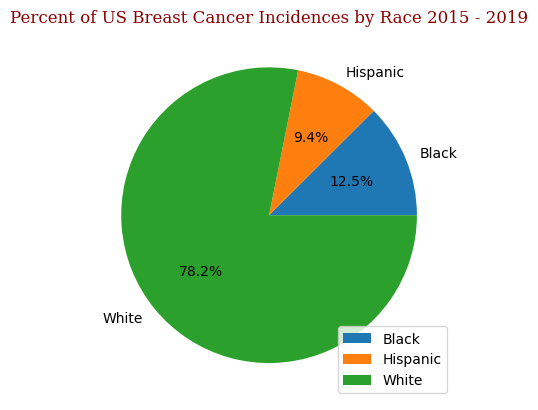

<Figure size 640x480 with 0 Axes>

In [41]:
# Pie chart showing total mix % by race (incidence)

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}
plt.pie(df2_gb_pie_i["incidence"], labels=df2_gb_pie_i["Race"], autopct="%1.1f%%")
plt.title("Percent of US Breast Cancer Incidences by Race 2015 - 2019", fontdict=font)
plt.legend(loc="lower right")
plt.show()



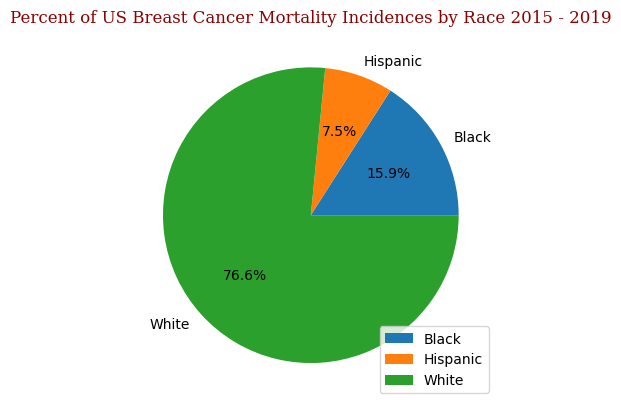

<Figure size 640x480 with 0 Axes>

In [42]:
# Pie chart showing total mix % by race (mortality)

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}
plt.pie(df2_gb_pie_m["mortality"], labels=df2_gb_pie_m["Race"], autopct="%1.1f%%")
plt.title("Percent of US Breast Cancer Mortality Incidences by Race 2015 - 2019", fontdict=font)
plt.legend(loc="lower right")
plt.show()



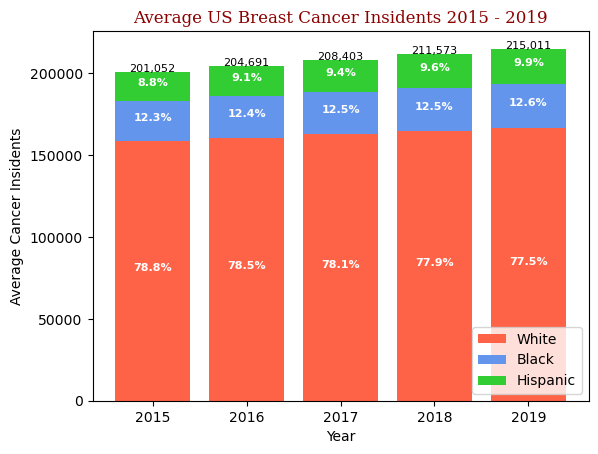

<Figure size 640x480 with 0 Axes>

In [43]:
# Plot mix % of race by year (incidence)

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig, ax = plt.subplots()

colors = ['tomato', 'cornflowerblue', 'limegreen']
bottom = np.zeros(len(df_summ))

for i, col in enumerate(df_summ.columns):
    ax.bar(df_summ.index, df_summ[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(df_summ[col])

totals = df_summ.sum(axis=1)
y_offset = 50

for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, f'{round(total):,.0f}', ha='center', size=8)

# Add percentages as labels
for idx in df_summ.index:
    start = 0
    for col in df_summ.columns:
        y = df_summ.loc[idx, col]
        value = df_summ.loc[idx, col]
        total = df_summ.loc[idx, :].sum()
        ax.text(
            x=idx,
            y=start + y / 2,
            s=f"{round(100 * value / total, 1)}%",
            fontsize=8,
            weight='bold',
            ha="center",
            color="w",
        )
        start += y

ax.set_title('Average US Breast Cancer Insidents 2015 - 2019', fontdict=font)
ax.set_xlabel('Year')
ax.set_ylabel('Average Cancer Insidents')
ax.legend(loc='lower right')
plt.show()



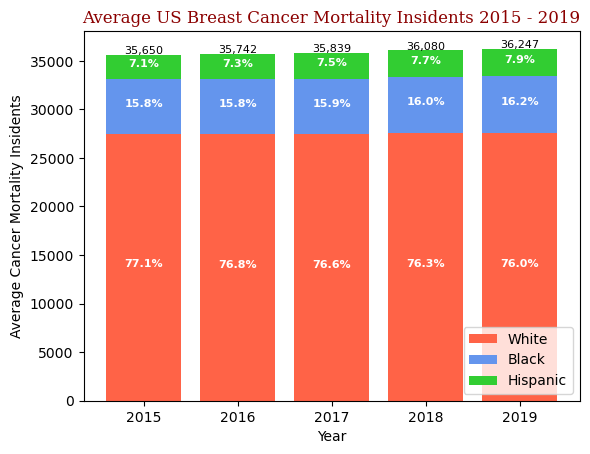

<Figure size 640x480 with 0 Axes>

In [52]:
# Plot mix % of race by year (mortality)

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig, ax = plt.subplots()

colors = ['tomato', 'cornflowerblue', 'limegreen']
bottom = np.zeros(len(df_summ_m))

for i, col in enumerate(df_summ_m.columns):
    ax.bar(df_summ_m.index, df_summ_m[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(df_summ_m[col])

totals = df_summ_m.sum(axis=1)
y_offset = 50

for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, f'{round(total):,.0f}', ha='center', size=8)

# Add percentages as labels
for idx in df_summ_m.index:
    start = 0
    for col in df_summ_m.columns:
        y = df_summ_m.loc[idx, col]
        value = df_summ_m.loc[idx, col]
        total = df_summ_m.loc[idx, :].sum()
        ax.text(
            x=idx,
            y=start + y / 2,
            s=f"{round(100 * value / total, 1)}%",
            fontsize=8,
            weight='bold',
            ha="center",
            color="w",
        )
        start += y

ax.set_title('Average US Breast Cancer Mortality Insidents 2015 - 2019', fontdict=font)
ax.set_xlabel('Year')
ax.set_ylabel('Average Cancer Mortality Insidents')
ax.legend(loc='lower right')
plt.show()



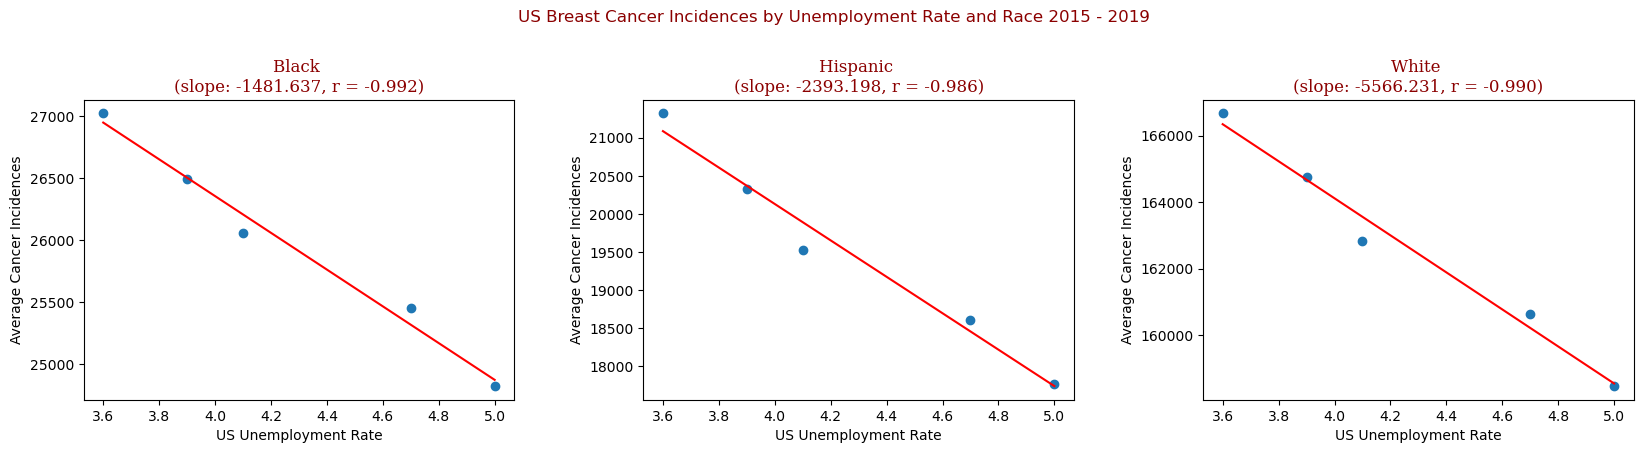

In [45]:
# Plot cancer incidences by unemployment rate by year

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Incidences by Unemployment Rate and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'unemployment_rate'].values
    y = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'incidence'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('US Unemployment Rate')
    ax.set_ylabel('Average Cancer Incidences')

plt.savefig("Figures/C_US_IncidencesUnemploy.png")

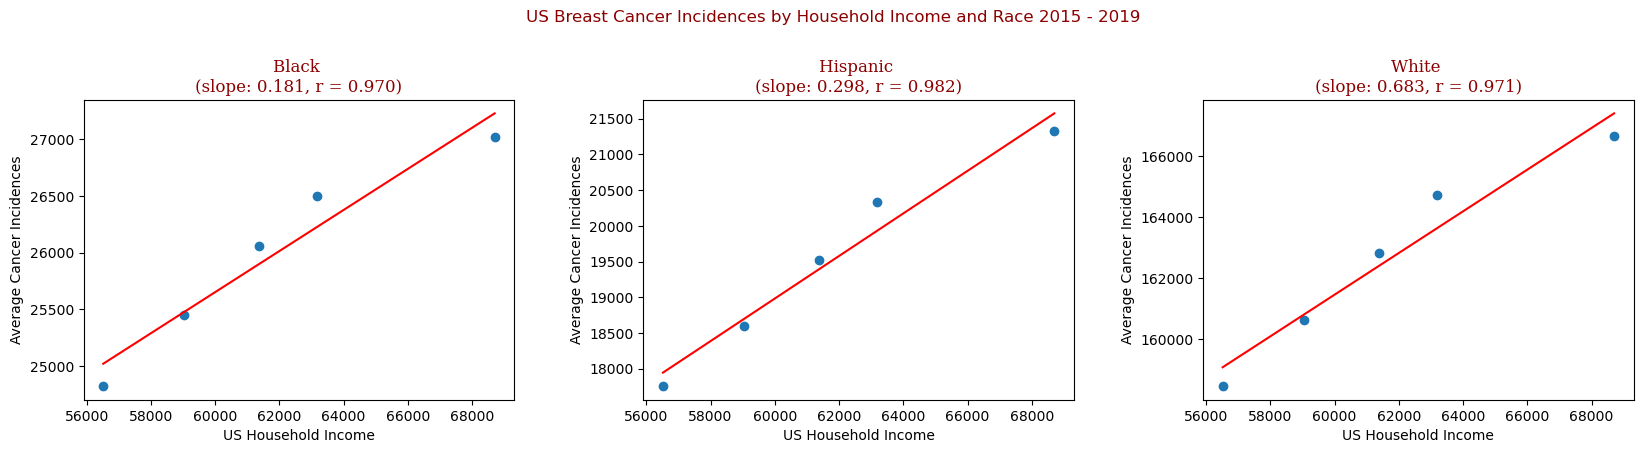

In [46]:
# Plot cancer incidences by household income by year

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Incidences by Household Income and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'household_income'].values
    y = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'incidence'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('US Household Income')
    ax.set_ylabel('Average Cancer Incidences')

plt.savefig("Figures/C_US_IncidencesIncome.png")

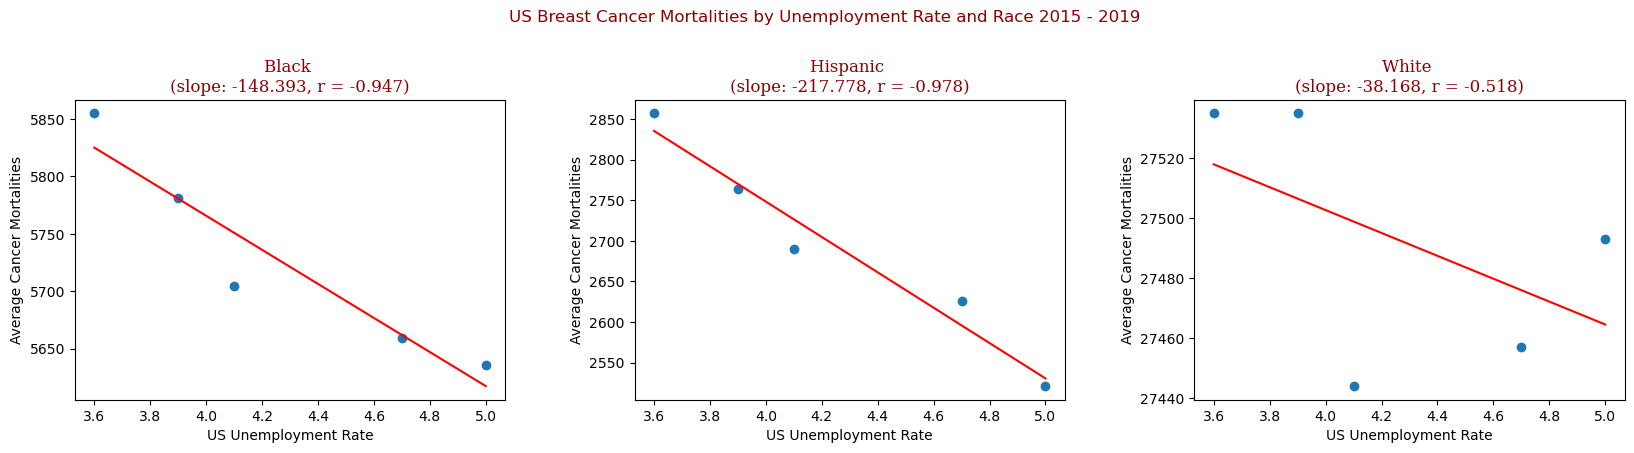

In [47]:
# Plot cancer mortalities by unemployment rate by year

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Mortalities by Unemployment Rate and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'unemployment_rate'].values
    y = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'mortality'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('US Unemployment Rate')
    ax.set_ylabel('Average Cancer Mortalities')

plt.savefig("Figures/C_US_MortalitiesUnemploy.png")

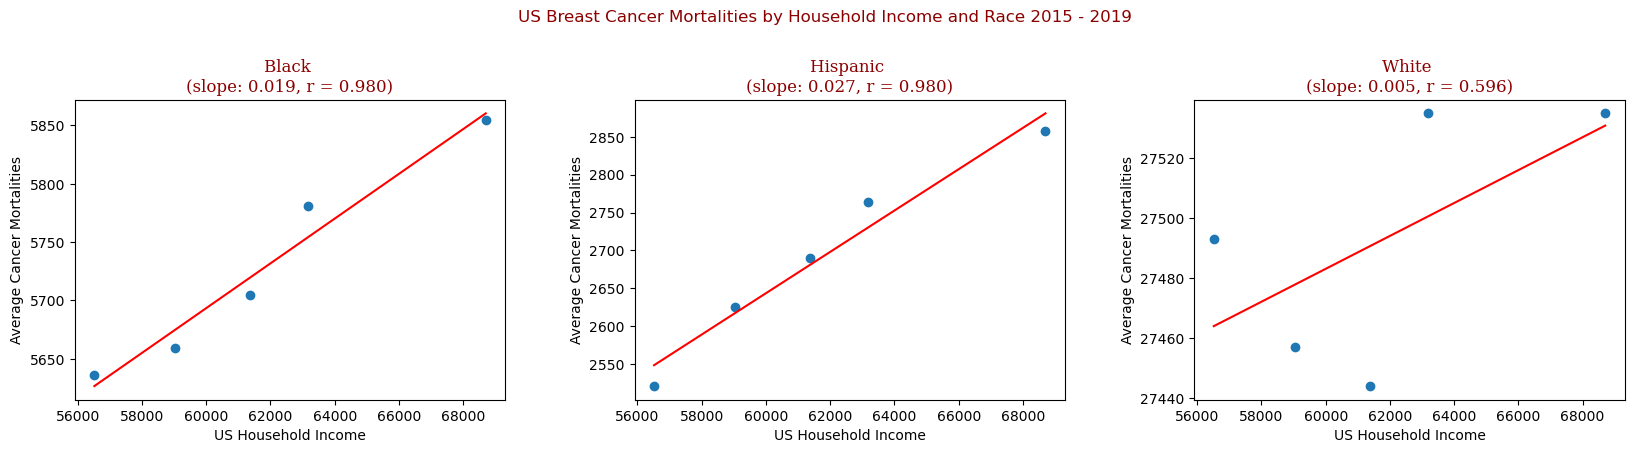

In [48]:
# Plot cancer mortalities by household income by year

font = {'family': 'serif', 'color': 'darkred', 'weight': 'normal', 'size': 12}

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=.3, top=.8, bottom=.2)
fig.suptitle(f'US Breast Cancer Mortalities by Household Income and Race 2015 - 2019', fontsize=12, ha='center', color='darkred')

for n, race in df_race.iterrows():
    ax = fig.add_subplot(1, 3, n + 1)
    x = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'household_income'].values
    y = df_summ_us_clean.loc[(df_summ_us_clean['Race'] == race[0]), 'mortality'].values
    ax.scatter(x, y)
    lin_reg(np.array(x), np.array(y))
    r, p = st.pearsonr(np.array(x), np.array(y))
    z = np.polyfit(np.array(x), np.array(y), 1)
    ax.set_title(f'{race[0]} \n(slope: {z[0]:.3f}, r = {r:.3f})', fontdict=font)
    ax.set_xlabel('US Household Income')
    ax.set_ylabel('Average Cancer Mortalities')

plt.savefig("Figures/C_US_MortalitiesIncome.png")

In [49]:
filename = 'Resources/output-%s.xlsx' % get_dt()
with pd.ExcelWriter(filename) as writer:
    df_clean.to_excel(writer, sheet_name='data')